In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        spikes = (spikes > 0).astype(int)
        spike_times = [time[spike.astype(bool)] for spike in spikes.T]
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        spikes = (spikes > 0).astype(int)
        spike_times = [time[spike.astype(bool)] for spike in spikes.T]
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time, position2D

In [2]:
is_ripple, spikes, position, speed, env, time, position2D = load_data()
spikes = (spikes > 0).astype(int)
spike_times = [time[spike.astype(bool)] for spike in spikes.T]


sampling_frequency = 500
time_range = (time[0], time[-1] + (1 / sampling_frequency))

n_time_bins = int((time_range[-1] - time_range[0]) * sampling_frequency) + 1
t = time_range[0] + np.arange(n_time_bins) / sampling_frequency

np.allclose(t, time)

07-Jul-25 11:47:36 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


True

In [3]:
from non_local_detector import Environment

new_env = Environment.from_graph(
    graph=env.track_graph,
    edge_order=env.edge_order,
    edge_spacing=env.edge_spacing,
    bin_size=env.place_bin_size,
)

<Axes: title={'center': ' (Graph)'}>

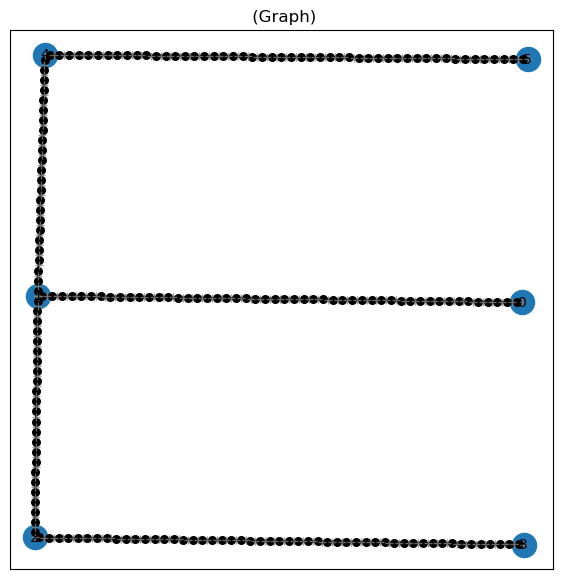

In [4]:
new_env.plot()

<Axes: title={'center': 'Graph Layout'}, xlabel='Linearized Position', ylabel='Bin Index'>

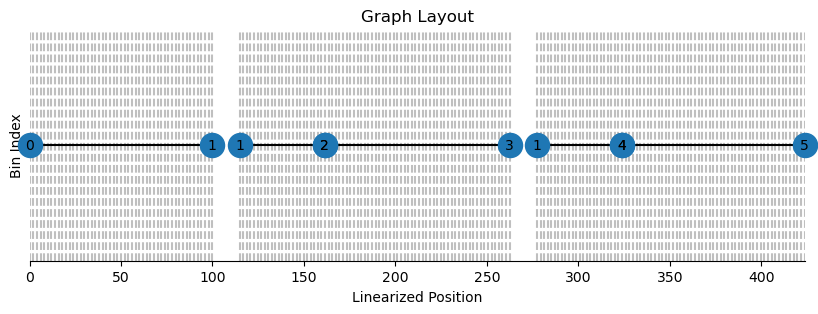

In [5]:
new_env.plot_1D()

In [6]:
(np.diff(new_env.to_linear(new_env.bin_centers)) < 1.5).nonzero()[
    0
]  # there are extra bins...

array([], dtype=int64)

/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


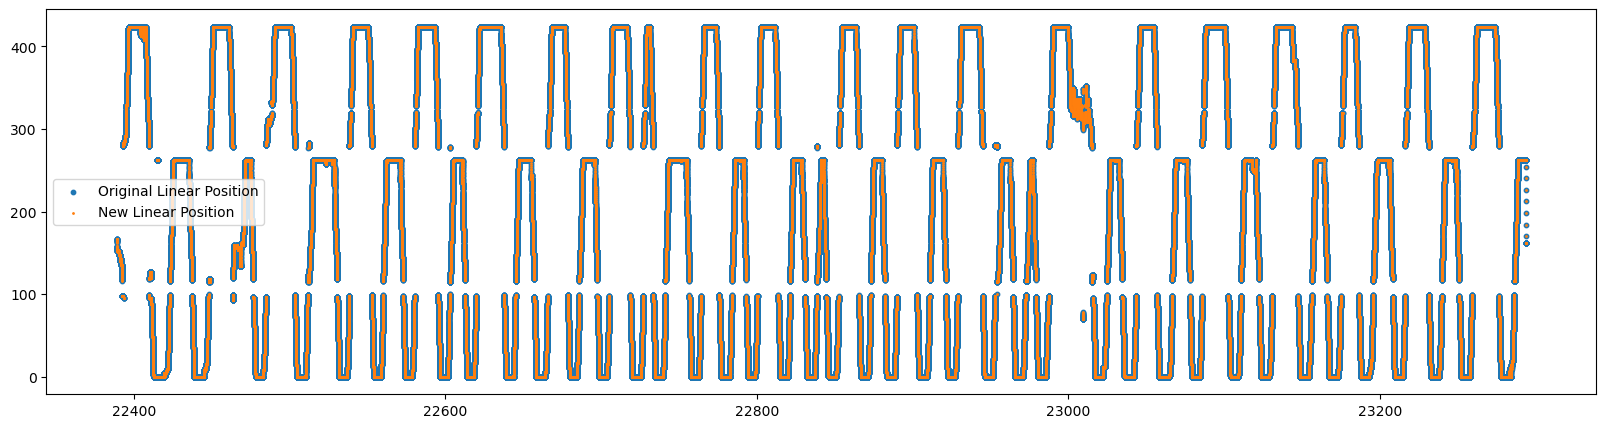

In [7]:
from track_linearization import get_linearized_position
import matplotlib.pyplot as plt

linear_pos = get_linearized_position(
    position=position2D,
    track_graph=env.track_graph,
    edge_order=env.edge_order,
    edge_spacing=env.edge_spacing,
).linear_position.to_numpy()
linear_pos2 = new_env.to_linear(position2D)


plt.figure(figsize=(20, 5))
plt.scatter(time, linear_pos, label="Original Linear Position", s=10)
plt.scatter(time, linear_pos2, label="New Linear Position", s=1)
plt.legend()
plt.show()

In [8]:
from non_local_detector import SortedSpikesDecoder

decoder = SortedSpikesDecoder(
    environments=[new_env],
    sorted_spikes_algorithm="sorted_spikes_diffusion_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

07-Jul-25 11:48:02 Fitting initial conditions...
07-Jul-25 11:48:02 Fitting discrete state transition
07-Jul-25 11:48:02 Fitting continuous state transition...
07-Jul-25 11:48:02 Fitting place fields...


Computing diffusion kernels...
Computed (199, 199) kernel matrix.
Calculating smoothed occupancy...


07-Jul-25 11:48:05 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
07-Jul-25 11:48:05 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Encoding models (Diffusion):   0%|          | 0/104 [00:00<?, ?neuron/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/environment/layout/mixins.py:165: RuntimeWarning: KDTree query failed: x must consist of vectors of length 2 but has shape (28981, 1). Returning -1 for all points.
  warnings.warn(
/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/environment/layout/mixins.py:165: RuntimeWarning: KDTree query failed: x must consist of vectors of length 2 but has shape (2538, 1). Returning -1 for all points.
  warnings.warn(
/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/environment/layout/mixins.py:165: RuntimeWarning: KDTree query failed: x must consist of vectors of length 2 but has shape (1307, 1). Returning -1 for all points.
  warnings.warn(
/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/environment/layout/mixins.py:165: RuntimeWarning: KDTree query failed: x must consist of vectors of length 2 but has shape (3185, 1). Returning -1 for all points.
  warnin

In [ ]:
from non_local_detector import SortedSpikesDecoder

decoder = SortedSpikesDecoder(
    sorted_spikes_algorithm="sorted_spikes_diffusion_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

In [ ]:
from non_local_detector import SortedSpikesDecoder

decoder2 = SortedSpikesDecoder(
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


def plot_place_fields_comparison(
    decoder,
    decoder2,
    neuron_ind=1,
    sampling_frequency=500.0,
):
    place_fields = decoder.encoding_model_[("", 0)]["place_fields"]
    place_fields2 = decoder2.encoding_model_[("", 0)]["place_fields"]

    place_fields_2d = np.zeros_like(decoder.environments[0].active_mask, dtype=float)
    place_fields_2d[decoder.environments[0].active_mask] = (
        place_fields[neuron_ind] * sampling_frequency
    )

    place_fields_2d_2 = np.zeros_like(decoder2.environments[0].active_mask, dtype=float)
    place_fields_2d_2[decoder2.environments[0].active_mask] = (
        place_fields2[neuron_ind] * sampling_frequency
    )

    # get maximum value for color scaling
    vmax1 = np.max(place_fields_2d)
    vmax2 = np.max(place_fields_2d_2)
    vmax = max(vmax1, vmax2)
    diff_vmax = max(
        np.abs(np.min(place_fields_2d_2 - place_fields_2d)),
        np.abs(np.max(place_fields_2d_2 - place_fields_2d)),
    )

    fig, axes = plt.subplots(
        1, 3, figsize=(12, 4), constrained_layout=True, sharex=True, sharey=True
    )

    # KDE Place Fields
    pcm0 = axes[0].pcolormesh(
        decoder2.environments[0].grid_edges[0],
        decoder2.environments[0].grid_edges[1],
        place_fields_2d_2.T,
        vmin=0.0,
        vmax=vmax,
        cmap="viridis",
        shading="auto",
    )
    axes[0].set_xlabel("X Position (cm)", fontsize=12)
    axes[0].set_ylabel("Y Position (cm)", fontsize=12)
    axes[0].set_title("KDE Place Fields", fontsize=14, pad=10)
    axes[0].grid(False)
    axes[0].tick_params(axis="both", which="major", labelsize=10)
    axes[0].xaxis.set_major_locator(mticker.MaxNLocator(5))
    axes[0].yaxis.set_major_locator(mticker.MaxNLocator(5))

    # Diffusion Place Fields
    pcm1 = axes[1].pcolormesh(
        decoder.environments[0].grid_edges[0],
        decoder.environments[0].grid_edges[1],
        place_fields_2d.T,
        vmin=0.0,
        vmax=vmax,
        cmap="viridis",
        shading="auto",
    )
    axes[1].set_xlabel("X Position (cm)", fontsize=12)
    axes[1].set_title("Diffusion Place Fields", fontsize=14, pad=10)
    axes[1].grid(False)
    axes[1].tick_params(axis="both", which="major", labelsize=10)
    axes[1].xaxis.set_major_locator(mticker.MaxNLocator(5))
    axes[1].yaxis.set_major_locator(mticker.MaxNLocator(5))

    # Difference
    pcm2 = axes[2].pcolormesh(
        decoder.environments[0].grid_edges[0],
        decoder.environments[0].grid_edges[1],
        (place_fields_2d_2 - place_fields_2d).T,
        vmin=-diff_vmax,
        vmax=diff_vmax,
        cmap="RdBu_r",
        shading="auto",
    )
    axes[2].set_xlabel("X Position (cm)", fontsize=12)
    axes[2].set_title("Difference (KDE - Diffusion)", fontsize=14, pad=10)
    axes[2].grid(False)
    axes[2].tick_params(axis="both", which="major", labelsize=10)
    axes[2].xaxis.set_major_locator(mticker.MaxNLocator(5))
    axes[2].yaxis.set_major_locator(mticker.MaxNLocator(5))

    # Remove spines for Tufte minimalism
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.8)
        ax.spines["bottom"].set_linewidth(0.8)

    # Single colorbar for all plots, placed below
    cbar = fig.colorbar(
        pcm1, ax=axes[:2], orientation="horizontal", fraction=0.05, pad=0.08
    )
    cbar.set_label("Place Field Activity (spikes/s)", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    cbar2 = fig.colorbar(
        pcm2, ax=axes[2], orientation="horizontal", fraction=0.05, pad=0.08
    )
    cbar2.set_label("Difference", fontsize=12)
    cbar2.ax.tick_params(labelsize=10)

    fig.suptitle(f"Comparison of Place Fields (KDE vs Diffusion) - Neuron {neuron_ind}", fontsize=16, y=1.06)
    plt.show()


plot_place_fields_comparison(decoder, decoder2, neuron_ind=1)

In [ ]:
plot_place_fields_comparison(decoder, decoder2, neuron_ind=0)

In [ ]:
plot_place_fields_comparison(decoder, decoder2, neuron_ind=3)

In [ ]:
plot_place_fields_comparison(decoder, decoder2, neuron_ind=4)

In [ ]:
plot_place_fields_comparison(decoder, decoder2, neuron_ind=5)

In [ ]:
from non_local_detector.model_checking.sorted_spikes import TimeRescaling
from non_local_detector.likelihoods.common import get_spikecount_per_time_bin


neuron_ind = 1

is_spike = get_spikecount_per_time_bin(spike_times[neuron_ind], time)

place_fields = decoder.encoding_model_[("", 0)]["place_fields"]
place_fields2 = decoder2.encoding_model_[("", 0)]["place_fields"]


bin_ind = decoder.environments[0].bin_at(position2D)
ci = place_fields[neuron_ind][bin_ind]
ci2 = place_fields2[neuron_ind][bin_ind]

ts = TimeRescaling(
    conditional_intensity=ci,
    is_spike=is_spike,
)

ts2 = TimeRescaling(
    conditional_intensity=ci2,
    is_spike=is_spike,
)

scatter_kwargs = {"s": 10}
ts.plot_ks(scatter_kwargs={**scatter_kwargs, "label": "Diffusion"})

ts2.plot_ks(scatter_kwargs={**scatter_kwargs, "label": "KDE"})
plt.title(f"Time Rescaling Comparison (Neuron {neuron_ind})", fontsize=14)
plt.legend(fontsize=12)

In [ ]:
neuron_ind = 3

is_spike = get_spikecount_per_time_bin(spike_times[neuron_ind], time)

place_fields = decoder.encoding_model_[("", 0)]["place_fields"]
place_fields2 = decoder2.encoding_model_[("", 0)]["place_fields"]


bin_ind = decoder.environments[0].bin_at(position2D)
ci = place_fields[neuron_ind][bin_ind]
ci2 = place_fields2[neuron_ind][bin_ind]

ts = TimeRescaling(
    conditional_intensity=ci,
    is_spike=is_spike,
)

ts2 = TimeRescaling(
    conditional_intensity=ci2,
    is_spike=is_spike,
)

scatter_kwargs = {"s": 10}
ts.plot_ks(scatter_kwargs={**scatter_kwargs, "label": "Diffusion"})

ts2.plot_ks(scatter_kwargs={**scatter_kwargs, "label": "KDE"})
plt.title(f"Time Rescaling Comparison (Neuron {neuron_ind})", fontsize=14)
plt.legend(fontsize=12)

In [ ]:
neuron_ind = 4

is_spike = get_spikecount_per_time_bin(spike_times[neuron_ind], time)

place_fields = decoder.encoding_model_[("", 0)]["place_fields"]
place_fields2 = decoder2.encoding_model_[("", 0)]["place_fields"]


bin_ind = decoder.environments[0].bin_at(position2D)
ci = place_fields[neuron_ind][bin_ind]
ci2 = place_fields2[neuron_ind][bin_ind]

ts = TimeRescaling(
    conditional_intensity=ci,
    is_spike=is_spike,
)

ts2 = TimeRescaling(
    conditional_intensity=ci2,
    is_spike=is_spike,
)

scatter_kwargs = {"s": 10}
ts.plot_ks(scatter_kwargs={**scatter_kwargs, "label": "Diffusion"})

ts2.plot_ks(scatter_kwargs={**scatter_kwargs, "label": "KDE"})
plt.title(f"Time Rescaling Comparison (Neuron {neuron_ind})", fontsize=14)
plt.legend(fontsize=12)

In [ ]:
neuron_ind = 5

is_spike = get_spikecount_per_time_bin(spike_times[neuron_ind], time)

place_fields = decoder.encoding_model_[("", 0)]["place_fields"]
place_fields2 = decoder2.encoding_model_[("", 0)]["place_fields"]


bin_ind = decoder.environments[0].bin_at(position2D)
ci = place_fields[neuron_ind][bin_ind]
ci2 = place_fields2[neuron_ind][bin_ind]

ts = TimeRescaling(
    conditional_intensity=ci,
    is_spike=is_spike,
)

ts2 = TimeRescaling(
    conditional_intensity=ci2,
    is_spike=is_spike,
)

scatter_kwargs = {"s": 10}
ts.plot_ks(scatter_kwargs={**scatter_kwargs, "label": "Diffusion"})

ts2.plot_ks(scatter_kwargs={**scatter_kwargs, "label": "KDE"})
plt.title(f"Time Rescaling Comparison (Neuron {neuron_ind})", fontsize=14)
plt.legend(fontsize=12)

In [ ]:
bin_ind = decoder.environments[0].bin_at(position2D)
min(bin_ind), max(bin_ind), decoder.environments[0].n_bins

In [ ]:
decoder.initial_conditions_

In [ ]:
new_env.n_bins, decoder.initial_conditions_.shape

In [ ]:
decoder.plot_initial_conditions()

In [ ]:
decoder.plot_continuous_state_transition(figsize_scaling=6)

In [ ]:
occupancy = decoder.encoding_model_[("", 0)]["occupancy"]
mean_rates = decoder.encoding_model_[("", 0)]["mean_rates"]
place_fields = decoder.encoding_model_[("", 0)]["place_fields"]
no_spike_part_log_likelihood = decoder.encoding_model_[("", 0)][
    "no_spike_part_log_likelihood"
]
linear_bin_centers = new_env.to_linear(new_env.bin_centers)
position_1D = new_env.to_linear(position2D)

In [ ]:
from track_linearization import plot_graph_as_1D

fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(linear_bin_centers, occupancy, label="Occupancy", s=10)
plot_graph_as_1D(
    env.track_graph,
    edge_order=env.edge_order,
    edge_spacing=env.edge_spacing,
    ax=ax,
)
ax.hist(
    position_1D,
    bins=linear_bin_centers,
    density=True,
    alpha=0.5,
    label="Position Histogram",
)
ax.set_xlabel("Linear Position (cm)")

In [ ]:
from track_linearization import plot_track_graph
import networkx as nx

plot_track_graph(
    env.track_graph,
)

pos = nx.get_node_attributes(env.track_graph, "pos")

for i, (x, y) in pos.items():
    plt.text(x, y, str(i), fontsize=12, ha="center", va="center")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist2d(
    position2D[:, 0],
    position2D[:, 1],
    bins=100,
    cmap="Blues",
    density=True,
    cmin=0.0,
    cmax=0.005,
)
plt.colorbar(label="Counts")
plt.xlabel("Nose X Position")
plt.ylabel("Nose Y Position")

In [ ]:
plt.plot(linear_bin_centers, place_fields.T)
plt.xlabel("Linear Position (cm)")

In [ ]:
results = decoder.predict(
    spike_times=spike_times,
    time=time,
)

In [ ]:
posterior = results.acausal_posterior.unstack("state_bins").sum("state")

In [ ]:
time_slice = slice(0, 30_000)

fig, ax = plt.subplots(figsize=(20, 5))
posterior.isel(time=time_slice).plot(x="time", y="position", ax=ax, cmap="bone_r")
ax.set_title("Posterior Position")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position (cm)")
ax.scatter(
    time[time_slice],
    new_env.to_linear(position2D[time_slice]),
    s=1,
    color="magenta",
    label="True Position",
)

In [ ]:
from non_local_detector import SortedSpikesDecoder

decoder2 = SortedSpikesDecoder(
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

In [ ]:
results2 = decoder2.predict(
    spike_times=spike_times,
    time=time,
)

In [ ]:
posterior = results2.acausal_posterior.unstack("state_bins").sum("state")

In [ ]:
posterior

In [ ]:
position_info_df = pd.DataFrame(
    {
        "x_position": position2D[:, 0],
        "y_position": position2D[:, 1],
        "head_direction": np.random.uniform(0, 2 * np.pi, size=position2D.shape[0]),
        "speed": speed,
    },
    index=pd.Index(time, name="time"),
)
position_info_df.shape, posterior.shape

In [ ]:
import xarray as xr

multiunit_firing_rate_xr = xr.DataArray(
    data=np.random.rand(
        len(time),
    ),
    dims=["time"],
    coords={"time": time},
    name="multiunit_firing_rate",
)

In [ ]:
import logging
import time
from collections import OrderedDict
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import xarray as xr
from bokeh.layouts import column, row
from bokeh.models import Button, ColumnDataSource, Div, Range1d, Select, Slider
from bokeh.palettes import Viridis256
from bokeh.plotting import curdoc, figure

# Optional imports for big data support
try:
    import dask.array as da
    import zarr

    DASK_AVAILABLE = True
except ImportError:
    DASK_AVAILABLE = False


class EnhancedNeuralViewer:
    def __init__(
        self,
        position_info_df=None,
        posterior_xr=None,
        multiunit_firing_rate_xr=None,
        non_local_prob_xr=None,
        sampling_frequency=250,
    ):
        """
        Enhanced viewer for your actual data structure

        Parameters match your simulation exactly:
        - position_info_df: DataFrame with x, y, speed, head_direction (time as index or column)
        - posterior_xr: acausal_posterior DataArray (time, x_position, y_position)
        - multiunit_firing_rate_xr: MUA DataArray
        - non_local_prob_xr: non-local probability DataArray
        """
        self.setup_logging()
        self.sampling_frequency = sampling_frequency

        # Use provided data or generate demo data
        if position_info_df is not None:
            self._load_real_data(
                position_info_df,
                posterior_xr,
                multiunit_firing_rate_xr,
                non_local_prob_xr,
            )
        else:
            self._generate_demo_data()

        # Current state
        self.current_time_idx = 0
        self.playing = False
        self.window_duration = 0.8  # ±0.4s like your HoloViews
        self.updating_slider = False  # Flag to prevent callback loops

        # Scalability optimizations
        self.max_cache_size = min(1000, self.n_time // 10)  # Adaptive cache size
        self.frame_cache = OrderedDict()  # Fast LRU eviction
        self.preload_radius = min(50, self.n_time // 20)  # Adaptive preload

        # Adjust cache sizes for chunked data
        if hasattr(self, "is_chunked") and self.is_chunked:
            # Smaller cache for chunked data to preserve memory
            self.max_cache_size = min(200, self.max_cache_size)
            self.preload_radius = min(20, self.preload_radius)
            self.log_info("Reduced cache sizes for chunked data mode")

        # Use ThreadPoolExecutor for robust preloading
        self.preload_executor = ThreadPoolExecutor(
            max_workers=2, thread_name_prefix="neural_preload"
        )
        self.preload_futures = set()  # Track active futures

        # On-demand decimation (not at init)
        self.use_decimation = self.n_time > 10000
        self.decimation_factor = (
            max(1, self.n_time // 10000) if self.use_decimation else 1
        )
        self._decimated_cache = {}  # Cache decimated data when needed

        # Setup logging instead of print statements
        self.setup_logging()

        if self.use_decimation:
            self.log_info(
                f"Large dataset detected ({self.n_time} frames). Will use on-demand decimation factor {self.decimation_factor}"
            )

        # Memory management
        self.last_cleanup = time.time()
        self.cleanup_interval = 30  # seconds

        # Precompute trigonometric values for head direction
        self.head_radius = 4.0
        self._precompute_head_direction_arrays()

        # Setup
        self._create_data_sources()
        self._create_plots()
        self._setup_callbacks()

        self.log_info(f"EnhancedNeuralViewer initialized: {self.n_time:,} time points")

    def setup_logging(self):
        """Setup logging with UI display"""
        self.logger = logging.getLogger("neural_viewer")
        self.logger.setLevel(logging.INFO)

        # Create log display div
        self.log_div = Div(
            text="",
            width=600,
            height=60,
            styles={
                "font-family": "Monaco, monospace",
                "font-size": "10px",
                "background-color": "#f8f9fa",
                "border": "1px solid #dee2e6",
                "border-radius": "4px",
                "padding": "4px",
                "overflow-y": "auto",
            },
        )

    def log_info(self, message):
        """Log info message to UI"""
        timestamp = time.strftime("%H:%M:%S")
        log_msg = f"[{timestamp}] {message}"
        current_text = self.log_div.text
        # Keep last 3 messages
        lines = current_text.split("<br>") if current_text else []
        lines.append(log_msg)
        if len(lines) > 3:
            lines = lines[-3:]
        self.log_div.text = "<br>".join(lines)

    def log_error(self, message):
        """Log error message to UI"""
        timestamp = time.strftime("%H:%M:%S")
        log_msg = f"[{timestamp}] ERROR: {message}"
        current_text = self.log_div.text
        lines = current_text.split("<br>") if current_text else []
        lines.append(f'<span style="color: red;">{log_msg}</span>')
        if len(lines) > 3:
            lines = lines[-3:]
        self.log_div.text = "<br>".join(lines)

    def _load_real_data(
        self,
        position_info_df,
        posterior_xr,
        multiunit_firing_rate_xr,
        non_local_prob_xr,
    ):
        """Load your actual simulation data with big data support"""

        self.log_info("Loading real data...")

        # Handle DataFrame index
        if (
            hasattr(position_info_df, "index")
            and "time" not in position_info_df.columns
        ):
            self.position_df = position_info_df.reset_index()
        else:
            self.position_df = position_info_df.copy()

        # Detect and handle chunked/big data
        self.is_chunked = self._detect_chunked_data(posterior_xr)

        if self.is_chunked:
            self.log_info("Detected chunked/Dask array - enabling big data mode")
            self._setup_chunked_data(
                posterior_xr, multiunit_firing_rate_xr, non_local_prob_xr
            )
        else:
            self.log_info("Loading standard in-memory data")
            self._setup_standard_data(
                posterior_xr, multiunit_firing_rate_xr, non_local_prob_xr
            )

        # Extract position data (always small enough for memory)
        self.x_pos = self.position_df["x_position"].values
        self.y_pos = self.position_df["y_position"].values
        self.speed = self.position_df["speed"].values
        self.head_direction = self.position_df["head_direction"].values

        self.log_info(
            f"Loaded real data: {self.n_time:,} frames, {len(self.x_coords)}x{len(self.y_coords)} spatial bins"
        )

    def _detect_chunked_data(self, posterior_xr):
        """Detect if data is chunked/Dask-backed"""
        if not DASK_AVAILABLE:
            return False

        # Check if data is Dask-backed
        if hasattr(posterior_xr.data, "chunks"):
            return True

        # Check if data is very large (>1GB)
        data_size_gb = posterior_xr.nbytes / (1024**3)
        if data_size_gb > 1.0:
            self.log_info(f"Large dataset detected: {data_size_gb:.1f}GB")
            return True

        return False

    def _setup_chunked_data(
        self, posterior_xr, multiunit_firing_rate_xr, non_local_prob_xr
    ):
        """Setup for chunked/Dask arrays - memory efficient"""

        # Store references to chunked arrays without loading
        self.posterior = posterior_xr
        self.multiunit_firing_rate = multiunit_firing_rate_xr
        self.non_local_prob = non_local_prob_xr

        # Get dimensions efficiently
        self.n_time = len(posterior_xr.time)
        self.times = posterior_xr.time.values  # Coordinates are small
        self.x_coords = posterior_xr.x_position.values
        self.y_coords = posterior_xr.y_position.values

        # Chunked data settings
        self.chunk_size = self._get_optimal_chunk_size()
        self.chunk_cache = {}  # Cache loaded chunks
        self.max_chunks_cached = 5  # Limit memory usage

        self.log_info(f"Using chunked mode: {self.chunk_size} frames per chunk")

    def _setup_standard_data(
        self, posterior_xr, multiunit_firing_rate_xr, non_local_prob_xr
    ):
        """Setup for standard in-memory arrays"""

        self.posterior = posterior_xr
        self.multiunit_firing_rate = multiunit_firing_rate_xr
        self.non_local_prob = non_local_prob_xr

        self.n_time = len(posterior_xr.time)
        self.times = posterior_xr.time.values
        self.x_coords = posterior_xr.x_position.values
        self.y_coords = posterior_xr.y_position.values

        self.is_chunked = False

    def _get_optimal_chunk_size(self):
        """Calculate optimal chunk size based on available memory"""

        # Estimate memory per frame
        spatial_size = len(self.x_coords) * len(self.y_coords)
        bytes_per_frame = spatial_size * 4  # float32

        # Target 100MB chunks (adjust based on available RAM)
        target_chunk_mb = 100
        target_chunk_bytes = target_chunk_mb * 1024 * 1024

        chunk_size = max(1, target_chunk_bytes // bytes_per_frame)
        chunk_size = min(chunk_size, 1000)  # Cap at 1000 frames

        return chunk_size

    def _generate_demo_data(self):
        """Generate demo data matching your structure"""

        print("Generating demo data...")

        # Time parameters
        self.n_time = 2000
        self.times = np.arange(self.n_time) / self.sampling_frequency

        # Position trajectory
        self.x_pos = (
            50 + 25 * np.sin(self.times * 0.5) + 3 * np.random.randn(self.n_time)
        )
        self.y_pos = (
            50 + 25 * np.cos(self.times * 0.5) + 3 * np.random.randn(self.n_time)
        )
        self.speed = np.maximum(
            0, 15 + 10 * np.sin(self.times * 2) + 5 * np.random.randn(self.n_time)
        )
        self.head_direction = np.cumsum(np.random.randn(self.n_time) * 0.1)

        # Create position DataFrame
        self.position_df = pd.DataFrame(
            {
                "time": self.times,
                "x": self.x_pos,
                "y": self.y_pos,
                "speed": self.speed,
                "head_direction": self.head_direction,
            }
        )

        # Spatial coordinates
        self.x_coords = np.linspace(0, 100, 40)
        self.y_coords = np.linspace(0, 100, 40)

        # Generate posterior data
        posterior_data = np.zeros((self.n_time, len(self.x_coords), len(self.y_coords)))

        print("Generating posterior probability maps...")
        for t in range(0, self.n_time, 5):  # Every 5th frame for speed
            # Gaussian blob around true position with some offset/noise
            center_x = self.x_pos[t] + np.random.randn() * 3
            center_y = self.y_pos[t] + np.random.randn() * 3

            # Variable uncertainty based on speed
            sigma = 5 + (self.speed[t] / 30) * 5

            for i, x in enumerate(self.x_coords):
                for j, y in enumerate(self.y_coords):
                    dist_sq = (x - center_x) ** 2 + (y - center_y) ** 2
                    posterior_data[t, i, j] = np.exp(-dist_sq / (2 * sigma**2))

            # Normalize
            if posterior_data[t].sum() > 0:
                posterior_data[t] = posterior_data[t] / posterior_data[t].sum()

            # Copy to nearby frames
            for offset in range(1, min(5, self.n_time - t)):
                posterior_data[t + offset] = posterior_data[t]

        # Create xarray DataArray
        self.posterior = xr.DataArray(
            posterior_data,
            coords={
                "time": self.times,
                "x_position": self.x_coords,
                "y_position": self.y_coords,
            },
            dims=["time", "x_position", "y_position"],
            name="acausal_posterior",
        )

        # MUA firing rate
        base_rate = 15
        mua_rate = base_rate + self.speed * 0.3 + np.random.exponential(3, self.n_time)
        self.multiunit_firing_rate = xr.DataArray(
            mua_rate, coords={"time": self.times}, dims=["time"]
        )

        # Non-local probability
        nl_prob = (
            0.1
            + 0.4 * (1 / (1 + np.exp(-((self.speed - 20) / 10))))
            + 0.1 * np.random.rand(self.n_time)
        )
        nl_prob = np.clip(nl_prob, 0, 1)
        self.non_local_prob = xr.DataArray(
            nl_prob, coords={"time": self.times}, dims=["time"]
        )

    def _precompute_head_direction_arrays(self):
        """Precompute cos/sin arrays for efficient head direction rendering"""
        # Vectorized precomputation
        self.head_cos = self.head_radius * np.cos(self.head_direction)
        self.head_sin = self.head_radius * np.sin(self.head_direction)
        print("Precomputed head direction trigonometry")

    def _create_data_sources(self):
        """Create all data sources with memory optimization"""

        # Spatial plot sources
        self.trajectory_source = ColumnDataSource(data=dict(x=self.x_pos, y=self.y_pos))

        self.current_pos_source = ColumnDataSource(
            data=dict(x=[self.x_pos[0]], y=[self.y_pos[0]])
        )

        # Head direction line
        self.head_dir_source = ColumnDataSource(data=dict(x0=[], y0=[], x1=[], y1=[]))

        # MAP estimate (we'll calculate this)
        self.map_source = ColumnDataSource(data=dict(x=[], y=[]))

        # Heatmap image source (for efficient updates)
        self.heatmap_source = ColumnDataSource(
            data=dict(image=[], x=[], y=[], dw=[], dh=[])
        )

        # For large datasets, use on-demand decimation
        if self.use_decimation:
            # Get decimated data on-demand
            self.mua_full_source = ColumnDataSource(
                data=dict(
                    time=self._get_decimated_data_on_fly("mua_time"),
                    rate=self._get_decimated_data_on_fly("mua_rate"),
                )
            )

            self.speed_full_source = ColumnDataSource(
                data=dict(
                    time=self._get_decimated_data_on_fly("speed_time"),
                    speed=self._get_decimated_data_on_fly("speed_vals"),
                )
            )

            self.nonlocal_full_source = ColumnDataSource(
                data=dict(
                    time=self._get_decimated_data_on_fly("nonlocal_time"),
                    prob=self._get_decimated_data_on_fly("nonlocal_vals"),
                )
            )

            self.log_info(f"Using on-demand decimation: {self.decimation_factor}x")
        else:
            # Use full resolution for smaller datasets
            self.mua_full_source = ColumnDataSource(
                data=dict(
                    time=self.multiunit_firing_rate.time.values,
                    rate=self.multiunit_firing_rate.values,
                )
            )

            self.speed_full_source = ColumnDataSource(
                data=dict(time=self.times, speed=self.speed)
            )

            self.nonlocal_full_source = ColumnDataSource(
                data=dict(
                    time=self.non_local_prob.time.values,
                    prob=self.non_local_prob.values,
                )
            )

        # Time series sources - windowed data (always full resolution in window)
        self.mua_window_source = ColumnDataSource(data=dict(time=[], rate=[]))
        self.speed_window_source = ColumnDataSource(data=dict(time=[], speed=[]))
        self.nonlocal_window_source = ColumnDataSource(data=dict(time=[], prob=[]))

        # Time indicators
        self.mua_time_ind = ColumnDataSource(data=dict(time=[], y=[]))
        self.speed_time_ind = ColumnDataSource(data=dict(time=[], y=[]))
        self.nonlocal_time_ind = ColumnDataSource(data=dict(time=[], y=[]))

        print("Data sources created with scalability optimizations")

    def _get_decimated_data_on_fly(self, kind, window_start=None, window_end=None):
        """
        Returns decimated (downsampled) data for large datasets.
        Supports optional windowed selection for zoom/pan behavior.

        kind: str
            One of 'mua_time', 'mua_rate', 'speed_time', 'speed_vals', 'nonlocal_time', 'nonlocal_vals'
        """
        if not hasattr(self, "_decimated_cache"):
            self._decimated_cache = {}

        # Helper to decimate an array
        def decimate(arr, factor):
            if factor <= 1:
                return arr
            N = (len(arr) // factor) * factor
            arr = arr[:N]
            arr = arr.reshape(-1, factor)
            return arr.mean(axis=1)

        factor = self.decimation_factor if hasattr(self, "decimation_factor") else 1

        if kind == "mua_time":
            times = self.multiunit_firing_rate.time.values
            if window_start is not None and window_end is not None:
                mask = (times >= window_start) & (times <= window_end)
                times = times[mask]
            return decimate(times, factor)
        elif kind == "mua_rate":
            vals = self.multiunit_firing_rate.values
            if window_start is not None and window_end is not None:
                mask = (self.multiunit_firing_rate.time.values >= window_start) & (
                    self.multiunit_firing_rate.time.values <= window_end
                )
                vals = vals[mask]
            return decimate(vals, factor)
        elif kind == "speed_time":
            times = self.times
            if window_start is not None and window_end is not None:
                mask = (times >= window_start) & (times <= window_end)
                times = times[mask]
            return decimate(times, factor)
        elif kind == "speed_vals":
            vals = self.speed
            if window_start is not None and window_end is not None:
                mask = (self.times >= window_start) & (self.times <= window_end)
                vals = vals[mask]
            return decimate(vals, factor)
        elif kind == "nonlocal_time":
            times = self.non_local_prob.time.values
            if window_start is not None and window_end is not None:
                mask = (times >= window_start) & (times <= window_end)
                times = times[mask]
            return decimate(times, factor)
        elif kind == "nonlocal_vals":
            vals = self.non_local_prob.values
            if window_start is not None and window_end is not None:
                mask = (self.non_local_prob.time.values >= window_start) & (
                    self.non_local_prob.time.values <= window_end
                )
                vals = vals[mask]
            return decimate(vals, factor)
        else:
            raise ValueError(f"Unknown decimation kind: {kind}")

    def _create_plots(self):
        """Create all plots with improved aesthetics"""

        # === LEFT: SPATIAL PLOT ===
        self.spatial_plot = figure(
            width=500,
            height=500,
            title="Position Decoding",
            x_axis_label="X Position (cm)",
            y_axis_label="Y Position (cm)",
            tools="pan,wheel_zoom,box_zoom,reset",
            match_aspect=True,
            toolbar_location="above",
            title_location="above",
        )

        # Styling for spatial plot
        self.spatial_plot.title.text_font_size = "14pt"
        self.spatial_plot.title.text_color = "#2F2F2F"
        self.spatial_plot.axis.axis_label_text_font_size = "12pt"
        self.spatial_plot.axis.major_label_text_font_size = "10pt"
        self.spatial_plot.grid.grid_line_alpha = 0.3

        # Trajectory (subtle white line)
        self.spatial_plot.line(
            "x",
            "y",
            source=self.trajectory_source,
            alpha=0.4,
            line_width=1.5,
            color="white",
        )

        # Current position (prominent magenta dot)
        self.spatial_plot.scatter(
            "x",
            "y",
            source=self.current_pos_source,
            size=14,
            color="#FF1493",
            alpha=0.9,
            line_color="white",
            line_width=1,
        )

        # Head direction line (magenta)
        self.spatial_plot.segment(
            "x0",
            "y0",
            "x1",
            "y1",
            source=self.head_dir_source,
            color="#FF1493",
            line_width=3,
            alpha=0.9,
        )

        # MAP estimate (green with outline)
        self.spatial_plot.scatter(
            "x",
            "y",
            source=self.map_source,
            size=10,
            color="#32CD32",
            alpha=0.8,
            line_color="white",
            line_width=1,
        )

        # Heatmap (add once, update data source)
        self.heatmap_renderer = self.spatial_plot.image(
            image="image",
            x="x",
            y="y",
            dw="dw",
            dh="dh",
            source=self.heatmap_source,
            palette=Viridis256,
            alpha=0.85,
        )

        # === RIGHT: TIME SERIES PLOTS (STACKED) ===
        plot_width = 450
        plot_height = 150

        # Create shared x-range for linking
        self.shared_x_range = Range1d(start=0, end=self.window_duration)

        # Common styling function
        def style_timeseries_plot(plot, title_text):
            plot.title.text_font_size = "13pt"
            plot.title.text_color = "#2F2F2F"
            plot.axis.axis_label_text_font_size = "11pt"
            plot.axis.major_label_text_font_size = "9pt"
            plot.grid.grid_line_alpha = 0.2
            plot.toolbar_location = None  # Hide individual toolbars
            plot.outline_line_color = "#E0E0E0"
            plot.outline_line_width = 1
            return plot

        # MUA Rate Plot
        self.mua_plot = figure(
            width=plot_width,
            height=plot_height,
            title="Multiunit Activity",
            y_axis_label="Firing Rate (spikes/s)",
            tools="pan,wheel_zoom,box_zoom,reset",
            x_axis_label="",
            x_range=self.shared_x_range,
        )
        style_timeseries_plot(self.mua_plot, "Multiunit Activity")

        # Background data (subtle gray)
        self.mua_plot.line(
            "time",
            "rate",
            source=self.mua_full_source,
            alpha=0.25,
            line_width=1,
            color="#888888",
        )

        # Foreground data (dark blue)
        self.mua_plot.line(
            "time",
            "rate",
            source=self.mua_window_source,
            line_width=2.5,
            color="#1f77b4",
            alpha=0.9,
        )

        # Time cursor (bright red)
        self.mua_plot.line(
            "time",
            "y",
            source=self.mua_time_ind,
            line_width=2,
            color="#FF4444",
            line_dash="dashed",
            alpha=0.8,
        )

        # Speed Plot
        self.speed_plot = figure(
            width=plot_width,
            height=plot_height,
            title="Movement Speed",
            y_axis_label="Speed (cm/s)",
            tools="pan,wheel_zoom,box_zoom,reset",
            x_axis_label="",
            x_range=self.shared_x_range,
        )
        style_timeseries_plot(self.speed_plot, "Movement Speed")

        self.speed_plot.line(
            "time",
            "speed",
            source=self.speed_full_source,
            alpha=0.25,
            line_width=1,
            color="#888888",
        )
        self.speed_plot.line(
            "time",
            "speed",
            source=self.speed_window_source,
            line_width=2.5,
            color="#ff7f0e",
            alpha=0.9,
        )
        self.speed_plot.line(
            "time",
            "y",
            source=self.speed_time_ind,
            line_width=2,
            color="#FF4444",
            line_dash="dashed",
            alpha=0.8,
        )

        # Non-local Probability Plot
        self.nonlocal_plot = figure(
            width=plot_width,
            height=plot_height,
            title="Non-Local Events",
            x_axis_label="Time (s)",
            y_axis_label="Probability",
            tools="pan,wheel_zoom,box_zoom,reset",
            x_range=self.shared_x_range,
        )
        style_timeseries_plot(self.nonlocal_plot, "Non-Local Events")

        self.nonlocal_plot.line(
            "time",
            "prob",
            source=self.nonlocal_full_source,
            alpha=0.25,
            line_width=1,
            color="#888888",
        )
        self.nonlocal_plot.line(
            "time",
            "prob",
            source=self.nonlocal_window_source,
            line_width=2.5,
            color="#d62728",
            alpha=0.9,
        )
        self.nonlocal_plot.line(
            "time",
            "y",
            source=self.nonlocal_time_ind,
            line_width=2,
            color="#FF4444",
            line_dash="dashed",
            alpha=0.8,
        )

        self.log_info("Plots created with enhanced aesthetics")

    def _setup_callbacks(self):
        """Setup controls and callbacks with improved styling"""

        # === IMPROVED CONTROLS ===

        # Play/Pause button with better styling
        self.play_button = Button(
            label="▶ Play", width=100, height=40, button_type="primary"
        )

        # Speed control with better styling
        self.speed_select = Select(
            title="Playback Speed",
            value="1x",
            options=["1/8x", "1/4x", "1/2x", "1x", "2x", "4x", "8x"],
            width=120,
            height=60,
        )

        # Time window control with better styling
        self.window_select = Select(
            title="Time Window",
            value="0.8s",
            options=["0.4s", "0.8s", "1.6s", "3.2s", "6.4s"],
            width=120,
            height=60,
        )

        # Enhanced time slider (moved to bottom)
        self.time_slider = Slider(
            start=0,
            end=self.n_time - 1,
            value=0,
            step=1,
            title="Timeline",
            width=800,
            height=50,
            bar_color="#4287f5",
            show_value=False,  # Hide value display for cleaner look
        )

        # Styled info display
        self.info_div = Div(
            text="Ready",
            width=400,
            height=50,
            styles={
                "font-family": "Monaco, monospace",
                "font-size": "12px",
                "background-color": "#f8f9fa",
                "border": "1px solid #dee2e6",
                "border-radius": "4px",
                "padding": "8px",
            },
        )

        # Status display for performance info
        self.status_div = Div(
            text="",
            width=300,
            height=30,
            styles={
                "font-family": "Monaco, monospace",
                "font-size": "10px",
                "color": "#6c757d",
                "padding": "4px",
            },
        )

        # Callbacks
        self.time_slider.on_change(
            "value_throttled", self._on_time_change
        )  # Use value_throttled instead of value
        self.play_button.on_click(self._toggle_play)
        self.speed_select.on_change("value", self._on_speed_change)
        self.window_select.on_change("value", self._on_window_change)

        self.play_callback = None
        self.playback_interval = int(1000 / self.sampling_frequency)  # ms per frame

        # Link time series plot ranges for synchronized panning
        self._link_time_series_ranges()

        print("Callbacks setup")

    def _link_time_series_ranges(self):
        """Link time series plot ranges for synchronized panning"""

        # Add callback for when shared x-range changes
        def on_range_change(attr, old, new):
            # When user pans/zooms, update the current time based on center of view
            if hasattr(self.shared_x_range, "start") and hasattr(
                self.shared_x_range, "end"
            ):
                if (
                    self.shared_x_range.start is not None
                    and self.shared_x_range.end is not None
                ):
                    # Calculate center time of current view
                    center_time = (
                        self.shared_x_range.start + self.shared_x_range.end
                    ) / 2

                    # Find closest time index
                    time_diffs = np.abs(self.times - center_time)
                    closest_idx = np.argmin(time_diffs)

                    # Update slider (this will trigger _update_frame)
                    if closest_idx != self.current_time_idx:
                        self.time_slider.value = closest_idx

        self.shared_x_range.on_change("start", on_range_change)
        self.shared_x_range.on_change("end", on_range_change)

    def _on_time_change(self, attr, old, new):
        """Handle time slider changes - now using value_throttled for clean behavior"""
        # Ignore programmatic updates
        if self.updating_slider:
            return

        # Direct update with slider position sync
        try:
            target_frame = int(new)
            self._update_frame(target_frame)

            # Ensure slider visual position matches the target
            def sync_slider_position():
                self.updating_slider = True
                self.time_slider.value = target_frame
                self.updating_slider = False

            curdoc().add_next_tick_callback(sync_slider_position)

            print(f"Slider jumped to frame {target_frame}")
        except Exception as e:
            print(f"Error in slider update: {e}")

    def _on_window_change(self, attr, old, new):
        """Handle window size changes"""
        window_durations = {
            "0.4s": 0.4,
            "0.8s": 0.8,
            "1.6s": 1.6,
            "3.2s": 3.2,
            "6.4s": 6.4,
        }

        self.window_duration = window_durations.get(new, 0.8)

        # Update current view
        self._update_frame(self.current_time_idx)

    def _on_speed_change(self, attr, old, new):
        """Handle speed changes"""
        speed_multipliers = {
            "1/8x": 8.0,
            "1/4x": 4.0,
            "1/2x": 2.0,
            "1x": 1.0,
            "2x": 0.5,
            "4x": 0.25,
            "8x": 0.125,
        }

        multiplier = speed_multipliers.get(new, 1.0)
        self.playback_interval = int((1000 / self.sampling_frequency) * multiplier)

        # Update active playback
        if self.playing and self.play_callback:
            # Stop current playback
            curdoc().remove_periodic_callback(self.play_callback)
            # Start with new interval
            self.play_callback = curdoc().add_periodic_callback(
                self._advance_frame, self.playback_interval
            )

    def _update_frame(self, time_idx):
        """Update all displays for given time index"""
        if time_idx >= self.n_time:
            time_idx = self.n_time - 1

        self.current_time_idx = time_idx
        current_time = self.times[time_idx]

        # Update spatial heatmap
        self._update_heatmap(time_idx)

        # Update spatial markers
        self._update_spatial_markers(time_idx)

        # Update time series windows
        self._update_time_series_windows(current_time)

        # Calculate current values for info display
        current_speed = self.speed[time_idx] if time_idx < len(self.speed) else 0
        current_mua = (
            float(self.multiunit_firing_rate.values[time_idx])
            if time_idx < len(self.multiunit_firing_rate)
            else 0
        )
        current_nl = (
            float(self.non_local_prob.values[time_idx])
            if time_idx < len(self.non_local_prob)
            else 0
        )

        # Update info with enhanced formatting
        self.info_div.text = f"""
        <div style="line-height: 1.4;">
        <strong>Frame:</strong> {time_idx:,} / {self.n_time-1:,} &nbsp;&nbsp;
        <strong>Time:</strong> {current_time:.3f}s &nbsp;&nbsp;
        <strong>Speed:</strong> {current_speed:.1f} cm/s<br>
        <strong>MUA Rate:</strong> {current_mua:.1f} spikes/s &nbsp;&nbsp;
        <strong>Non-Local Prob:</strong> {current_nl:.3f}
        </div>
        """

        # Update status with cache info for large datasets
        if hasattr(self, "frame_cache"):
            cache_info = f"Cache: {len(self.frame_cache)}/{self.max_cache_size}"
            if self.use_decimation:
                cache_info += f" | Decimation: {self.decimation_factor}x"
            self.status_div.text = cache_info

    def _update_heatmap(self, time_idx):
        """Update spatial heatmap with chunked data support"""

        # Check cache first
        if time_idx in self.frame_cache:
            cached_data = self.frame_cache[time_idx]
            # Move to end (most recently used)
            self.frame_cache.move_to_end(time_idx)
            # Update with in-place assignment for speed
            self.heatmap_source.data.update(cached_data)
            return

        # Load frame data (handles both chunked and standard data)
        posterior_slice = self._load_frame_data(time_idx)

        # Cache the rendered data
        frame_data = dict(
            image=[posterior_slice],
            x=[self.x_coords.min()],
            y=[self.y_coords.min()],
            dw=[self.x_coords.max() - self.x_coords.min()],
            dh=[self.y_coords.max() - self.y_coords.min()],
        )

        # Update display with in-place update
        self.heatmap_source.data.update(frame_data)

        # Cache for future use (OrderedDict handles LRU automatically)
        if len(self.frame_cache) >= self.max_cache_size:
            # Remove least recently used (first item)
            self.frame_cache.popitem(last=False)

        self.frame_cache[time_idx] = frame_data

        # Schedule background preloading
        self._schedule_preload(time_idx)

    def _load_frame_data(self, time_idx):
        """Load frame data efficiently for both chunked and standard arrays"""

        if hasattr(self, "is_chunked") and self.is_chunked:
            return self._load_chunked_frame(time_idx)
        else:
            # Standard in-memory access
            return self.posterior.isel(time=time_idx).values

    def _load_chunked_frame(self, time_idx):
        """Efficiently load frame from chunked array"""

        # Determine which chunk this frame belongs to
        chunk_id = time_idx // self.chunk_size
        chunk_start = chunk_id * self.chunk_size
        chunk_end = min(chunk_start + self.chunk_size, self.n_time)

        # Check if chunk is already loaded
        if chunk_id in self.chunk_cache:
            chunk_data = self.chunk_cache[chunk_id]
        else:
            # Load chunk from disk/network
            try:
                self.log_info(
                    f"Loading chunk {chunk_id} (frames {chunk_start}-{chunk_end})"
                )
                chunk_data = self.posterior.isel(
                    time=slice(chunk_start, chunk_end)
                ).compute()

                # Cache management - keep only recent chunks
                if len(self.chunk_cache) >= self.max_chunks_cached:
                    # Remove oldest chunk
                    oldest_chunk = next(iter(self.chunk_cache))
                    del self.chunk_cache[oldest_chunk]

                self.chunk_cache[chunk_id] = chunk_data

            except Exception as e:
                self.log_error(f"Failed to load chunk {chunk_id}: {e}")
                # Fallback: load just this frame
                return self.posterior.isel(time=time_idx).compute().values

        # Extract specific frame from chunk
        frame_offset = time_idx - chunk_start
        return chunk_data.isel(time=frame_offset).values

    def _schedule_preload(self, center_idx):
        """Schedule preloading using ThreadPoolExecutor - robust and clean"""

        # Clean up completed futures
        self.preload_futures = {f for f in self.preload_futures if not f.done()}

        # Don't overload with too many futures
        if len(self.preload_futures) > 10:
            return

        for offset in range(-self.preload_radius, self.preload_radius + 1):
            target_idx = center_idx + offset
            if (
                0 <= target_idx < self.n_time
                and target_idx not in self.frame_cache
                and len(self.preload_futures) < 10
            ):

                # Submit preload task
                future = self.preload_executor.submit(self._preload_frame, target_idx)
                self.preload_futures.add(future)

    def _preload_frame(self, time_idx):
        """Preload a single frame in background thread with chunked support"""
        try:
            if time_idx in self.frame_cache:
                return  # Already cached

            # Load frame data (handles chunked arrays efficiently)
            posterior_slice = self._load_frame_data(time_idx)

            frame_data = dict(
                image=[posterior_slice],
                x=[self.x_coords.min()],
                y=[self.y_coords.min()],
                dw=[self.x_coords.max() - self.x_coords.min()],
                dh=[self.y_coords.max() - self.y_coords.min()],
            )

            # Cache with size management
            if len(self.frame_cache) < self.max_cache_size:
                self.frame_cache[time_idx] = frame_data

        except Exception as e:
            # Use logging instead of print
            self.log_error(f"Preload error for frame {time_idx}: {e}")

    def _update_spatial_markers(self, time_idx):
        """Update position markers with precomputed trigonometry"""
        # Current position
        curr_x = self.x_pos[time_idx]
        curr_y = self.y_pos[time_idx]

        # Use in-place update for speed
        self.current_pos_source.data.update(dict(x=[curr_x], y=[curr_y]))

        # Head direction using precomputed values (much faster)
        x_end = curr_x + self.head_cos[time_idx]
        y_end = curr_y + self.head_sin[time_idx]

        self.head_dir_source.data.update(
            dict(x0=[curr_x], y0=[curr_y], x1=[x_end], y1=[y_end])
        )

        # MAP estimate (find max probability position)
        posterior_slice = self._load_frame_data(time_idx)  # Use chunked-aware loading
        flat_idx = np.argmax(posterior_slice)
        x_idx, y_idx = np.unravel_index(flat_idx, posterior_slice.shape)
        map_x = self.x_coords[x_idx]
        map_y = self.y_coords[y_idx]

        self.map_source.data.update(dict(x=[map_x], y=[map_y]))

    def _update_time_series_windows(self, current_time):
        """Update scrolling windows with full resolution data in window"""

        # Window bounds
        window_start = current_time - (self.window_duration / 2)
        window_end = current_time + (self.window_duration / 2)

        # Safely update shared x-range
        try:
            self.shared_x_range.start = window_start
            self.shared_x_range.end = window_end
        except Exception as e:
            print(f"Warning: Could not update x-range: {e}")

        # Update MUA window data with on-the-fly decimation and vectorized operations
        if self.use_decimation:
            # Use full resolution data within window for detail
            mua_times_window = self._get_decimated_data_on_fly(
                "mua_time", window_start, window_end
            )
            mua_rates_window = self._get_decimated_data_on_fly(
                "mua_rate", window_start, window_end
            )
        else:
            # Regular vectorized masking for smaller datasets
            mua_mask = (self.multiunit_firing_rate.time.values >= window_start) & (
                self.multiunit_firing_rate.time.values <= window_end
            )
            mua_times_window = self.multiunit_firing_rate.time.values[mua_mask]
            mua_rates_window = self.multiunit_firing_rate.values[mua_mask]

        if len(mua_times_window) > 0:
            # In-place update for less GC pressure
            self.mua_window_source.data.update(
                dict(time=mua_times_window, rate=mua_rates_window)
            )

            # Time indicator with vectorized min/max
            mua_y_range = [
                np.min(self.multiunit_firing_rate.values),
                np.max(self.multiunit_firing_rate.values),
            ]
            self.mua_time_ind.data.update(
                dict(time=[current_time, current_time], y=mua_y_range)
            )

        # Update Speed window data (similar pattern)
        if self.use_decimation:
            speed_times_window = self._get_decimated_data_on_fly(
                "speed_time", window_start, window_end
            )
            speed_vals_window = self._get_decimated_data_on_fly(
                "speed_vals", window_start, window_end
            )
        else:
            speed_mask = (self.times >= window_start) & (self.times <= window_end)
            speed_times_window = self.times[speed_mask]
            speed_vals_window = self.speed[speed_mask]

        if len(speed_times_window) > 0:
            self.speed_window_source.data.update(
                dict(time=speed_times_window, speed=speed_vals_window)
            )

            speed_y_range = [np.min(self.speed), np.max(self.speed)]
            self.speed_time_ind.data.update(
                dict(time=[current_time, current_time], y=speed_y_range)
            )

        # Update Non-local window data (similar pattern)
        if self.use_decimation:
            nl_times_window = self._get_decimated_data_on_fly(
                "nonlocal_time", window_start, window_end
            )
            nl_probs_window = self._get_decimated_data_on_fly(
                "nonlocal_vals", window_start, window_end
            )
        else:
            nl_mask = (self.non_local_prob.time.values >= window_start) & (
                self.non_local_prob.time.values <= window_end
            )
            nl_times_window = self.non_local_prob.time.values[nl_mask]
            nl_probs_window = self.non_local_prob.values[nl_mask]

        if len(nl_times_window) > 0:
            self.nonlocal_window_source.data.update(
                dict(time=nl_times_window, prob=nl_probs_window)
            )

            self.nonlocal_time_ind.data.update(
                dict(time=[current_time, current_time], y=[0.0, 1.0])
            )

        # Periodic memory cleanup for large datasets
        if time.time() - self.last_cleanup > self.cleanup_interval:
            self._cleanup_memory()
            self.last_cleanup = time.time()

    def _cleanup_memory(self):
        """Periodic memory cleanup for large datasets"""
        try:
            # Limit cache size aggressively if memory usage is high
            if len(self.frame_cache) > self.max_cache_size * 0.8:
                # Keep only most recent frames
                current_idx = self.current_time_idx
                keys_to_keep = set(
                    range(
                        max(0, current_idx - self.preload_radius),
                        min(self.n_time, current_idx + self.preload_radius),
                    )
                )

                keys_to_remove = [
                    k for k in self.frame_cache.keys() if k not in keys_to_keep
                ]
                for k in keys_to_remove[
                    : len(keys_to_remove) // 2
                ]:  # Remove half of excess
                    del self.frame_cache[k]

                self.log_info(f"Cleaned cache: {len(keys_to_remove)//2} frames removed")

        except Exception as e:
            self.log_error(f"Error in memory cleanup: {e}")

    def _toggle_play(self):
        """Toggle play/pause with immediate responsiveness"""

        # Immediately toggle state and button label for instant feedback
        self.playing = not self.playing

        if self.playing:
            self.play_button.label = "Pause"
            print("Starting playback")
            # Start playback
            self.play_callback = curdoc().add_periodic_callback(
                self._advance_frame, self.playback_interval
            )
        else:
            self.play_button.label = "Play"
            print("Stopping playback")
            # Stop playback
            if self.play_callback is not None:
                try:
                    curdoc().remove_periodic_callback(self.play_callback)
                except:
                    pass
                self.play_callback = None

    def _advance_frame(self):
        """Advance to next frame during playback with robust error handling"""
        if not self.playing:
            return

        try:
            if self.current_time_idx < self.n_time - 1:
                # Calculate next frame
                next_idx = self.current_time_idx + 1

                # Update frame directly (bypass slider)
                self._update_frame(next_idx)

                # Update slider position safely
                def safe_update_slider():
                    try:
                        if self.playing and self.current_time_idx == next_idx:
                            self.updating_slider = True
                            self.time_slider.value = next_idx
                            self.updating_slider = False
                    except Exception as e:
                        print(f"Warning: Could not update slider: {e}")
                        self.updating_slider = False

                # Use next_tick for safer timing
                curdoc().add_next_tick_callback(safe_update_slider)

            else:
                # End of data - stop playback
                self._stop_playback()
                print("Reached end of data")
        except Exception as e:
            print(f"Error in _advance_frame: {e}")
            # Don't stop playback for minor errors, just continue
            pass

    def _stop_playback(self):
        """Helper to cleanly stop playback"""
        self.playing = False
        self.play_button.label = "Play"
        if self.play_callback:
            try:
                curdoc().remove_periodic_callback(self.play_callback)
            except:
                pass
            self.play_callback = None

    def create_layout(self):
        """Create elegant layout with time slider at bottom"""

        # === TOP CONTROL BAR ===
        control_bar = row(
            self.play_button,
            self.speed_select,
            self.window_select,
            self.info_div,
            sizing_mode="fixed",
        )

        # === MAIN CONTENT AREA ===
        # Time series column (right panel)
        time_series_column = column(
            self.mua_plot, self.speed_plot, self.nonlocal_plot, sizing_mode="fixed"
        )

        # Main plots row: spatial left, time series right
        main_plots = row(self.spatial_plot, time_series_column, sizing_mode="fixed")

        # === BOTTOM TIME CONTROL ===
        time_control_section = column(
            self.time_slider, self.status_div, sizing_mode="fixed"
        )

        # === COMPLETE LAYOUT WITH LOG DISPLAY ===
        return column(
            control_bar,
            main_plots,
            time_control_section,
            self.log_div,  # Add log display at bottom
            sizing_mode="fixed",
            margin=(10, 10, 10, 10),  # Add some margin around everything
        )


# Enhanced usage functions with big data support
def create_viewer_from_your_data(
    position_info_df,
    posterior_xr,
    multiunit_firing_rate_xr,
    non_local_prob_xr,
    sampling_frequency=250,
):
    """
    Create viewer using your exact data structure with automatic big data detection

    Supports:
    - Standard in-memory xarray DataArrays
    - Dask-backed chunked arrays
    - Zarr-backed arrays
    - Memory-mapped arrays
    """
    return EnhancedNeuralViewer(
        position_info_df=position_info_df,
        posterior_xr=posterior_xr,
        multiunit_firing_rate_xr=multiunit_firing_rate_xr,
        non_local_prob_xr=non_local_prob_xr,
        sampling_frequency=sampling_frequency,
    )


def load_chunked_data_example(data_path, chunk_size="100MB"):
    """
    Example of loading truly massive datasets with chunking

    For production use with huge datasets:

    # Method 1: Zarr (recommended for largest datasets)
    posterior_data = xr.open_zarr('huge_posterior.zarr', chunks={'time': 1000})

    # Method 2: NetCDF with Dask chunks
    posterior_data = xr.open_dataset('huge_posterior.nc', chunks={'time': 1000})

    # Method 3: Memory-mapped NumPy arrays
    posterior_array = np.memmap('huge_posterior.dat', dtype='float32',
                               shape=(500000, 512, 512), mode='r')
    posterior_data = xr.DataArray(posterior_array,
                                 dims=['time', 'x_position', 'y_position'])
    """

    if not DASK_AVAILABLE:
        raise ImportError("Dask not available. Install with: pip install dask[array]")

    # Example loading patterns
    examples = {
        "zarr": "xr.open_zarr('data.zarr', chunks={'time': 1000})",
        "netcdf": "xr.open_dataset('data.nc', chunks={'time': 1000})",
        "memmap": "np.memmap('data.dat', dtype='float32', shape=(N,H,W), mode='r')",
    }

    return examples


# Main execution
print("Starting enhanced neural viewer...")


viewer = create_viewer_from_your_data(
    position_info_df,
    posterior,
    multiunit_firing_rate_xr,
    results2.acausal_state_probabilities,
)

layout = viewer.create_layout()
curdoc().add_root(layout)
curdoc().title = "Enhanced Neural Decoding Viewer"
viewer.log_info("Enhanced layout ready!")

In [ ]:
posterior.shape